# Experiment on Cluster TSD Aggregation
Notebook to perform some model on a single TSD Cluster. During the flow, data is:
- decomposed with TSD in season, trend, residual
- seasonal cluster is applied to run seasonal model
- trend cluster is applied to run trend model
- residual cluster is applied to run residual model
- the three outputs are aggrgated to re-create the original signal.<br>

Data read are from table SLIDING_WINDOWS_DATASET that contains a sliding windows of:
- feats about last 7-days meteo values
- pollen value for the next day

Cluster associations are read from a local file: we have different cluster annotations made by different techniques.<br>
We explore different model & hyper-parameters throught Comet ML.

<h3>Import</h3>

In [1]:
from tqdm.auto import tqdm
import json
import math
import pandas as pd
import numpy as np
import datetime
import os
from datetime import timedelta
from google.cloud import bigquery

import seaborn as sns
from collections import Counter
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from plotly.offline import init_notebook_mode, iplot

from comet_ml import Experiment

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.experimental import Adam, AdamW, Adadelta
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

my_cmap = plt.get_cmap("Paired")
init_notebook_mode(connected=True)  
tqdm.pandas()

2023-04-21 12:56:44.290580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h3>Config</h3>

In [2]:
# Config

PROJECT_ID = 'arpae-prod-ml'

# BigQuery
BQ_DATASET = 'SAMPLE_DATA'
JOINED_BQ_DATASET = 'JOINED_DATA'

# Const
COMMON_PERIOD_INIT = '2011-01-01'
COMMON_PERIOD_END = '2021-12-31' 

TRAIN_END = '2016-12-31 00:00:00+00:00'
VAL_END = '2019-12-31 00:00:00+00:00'
TEST_END = '2022-12-31 00:00:00+00:00'

# Cols
DATE_COL = 'date'

# Cluster ids
SEASON_CLUSTER_ID = 4
TREND_CLUSTER_ID = 0
RESIDUAL_CLUSTER_ID = 0

# Feats
METEO_FEATS = ['week_amax', 
               'station_lat_amax', 'station_lon_amax', 'station_H_piano_strada_amax', 'station_H_mslm_amax', 
               'B13011_min_amin', 'B13011_max_amax', 'B13011_mean_mean', 'B13011_std_mean', 'B13011_sum_sum', 
               'B14198_min_amin', 'B14198_max_amax', 'B14198_mean_mean', 'B14198_std_mean', 'B14198_sum_sum',
               'TEMP_min_amin', 'TEMP_max_amax', 'TEMP_mean_mean', 'TEMP_std_mean', 'TEMP_sum_sum',
               'PREC_amin', 'PREC_mean', 'PREC_std', 'PREC_median', 'PREC_amax', 'PREC_skew', 'PREC_kurtosis']
POLLEN_FEATS = ['seasonal_mean', 'seasonal_prev_1', 'trend_mean', 'trend_prev_1', 'residual_mean', 'residual_prev_1',
                'pol_value_amin', 'pol_value_mean', 'pol_value_std', 'pol_value_median', 'pol_value_amax', 
                'pol_value_skew', 'pol_value_kurtosis',
                'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3',
                'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6',
                'pol_value_prev_7']
ORIGINAL_FEATS = METEO_FEATS + POLLEN_FEATS
LABELS_COL = ['season_label' , 'trend_label', 'residual_label', 'pol_value_label']

# Params
EPOCHS = 50
BATCH_SIZE = 512
SEQUENCE_LEN = 7

# Layout
COLOR_PALETTE = px.colors.qualitative.Prism

# Paths
SEASON_MODELS_PATH = "../../models/season/"
TREND_MODELS_PATH = "../../models/trend/"
RESIDUAL_MODELS_PATH = "../../models/residual/"

SEASON_OUTPUT_CLUSTER_FILENAME = "../../data/clustering_season_intervals.csv"
TREND_OUTPUT_CLUSTER_FILENAME = "../../data/clustering_trend_intervals.csv" 
RESIDUAL_OUTPUT_CLUSTER_FILENAME = "../../data/clustering_residual_intervals.csv"


<h3>Methods</h3>

In [3]:
# Read Methods

def _run_query(client, query): 
    df = client.query(query).to_dataframe()
    return df

def _read_table(client, project_id, dataset, table):
    query = "SELECT * FROM `{}.{}.{}` ".format(project_id, dataset, table)
    df = _run_query(client, query)
    return df

def _read_table_delta(client, project_id, dataset, table, date_col, init, end):
    query = "SELECT * FROM `{}.{}.{}` WHERE {} > '{}' AND {} < '{}' ".format(project_id, dataset, table, date_col, init, date_col, end)
    df = _run_query(client, query)
    if 'reftime' in df.columns:
        df.sort_values(by='reftime', inplace=True)
    elif date_col in df.columns:
        df.sort_values(by=date_col, inplace=True)
    else:
        return None
    return df


In [4]:
# Process Methods

def _normalize(x, range_dict, index_col, label_col):
    pol_min = range_dict[x[index_col]]['min']
    pol_max = range_dict[x[index_col]]['max']
    return (x[label_col] - pol_min) / (pol_max - pol_min)

In [5]:
# Data Methods

def _get_data(data_df, clusters_df, cluster_id, feats_cols, date_col, labels_col):
    
    # Filter clusters
    filt_clusters_df = clusters_df[clusters_df['cluster']==cluster_id]    
    dataset_df = pd.merge(data_df, filt_clusters_df, how='right', on=['station_id', 'pol_var_id'])

    # Create dataset
    dataset_df.sort_values(['station_id', 'pol_var_id', date_col], inplace=True)
    dataset_df = dataset_df[['station_id', 'pol_var_id', date_col]  + feats_cols + labels_col]
    
    # Set index and drop nan
    dataset_df.set_index(date_col, inplace=True)
    dataset_df.dropna(inplace=True)
    
    return dataset_df

def _prepare_data(dataset_df, original_feats, meteo_feats, pollen_feats, labels_col):
    # Add 1-hot encoding cols
    stations_one_hot = pd.get_dummies(dataset_df['station_id'], prefix='station_id')
    pollen_one_hot = pd.get_dummies(dataset_df['pol_var_id'], prefix='pol_var_id')
    dataset_df = pd.concat([dataset_df, stations_one_hot], axis=1)
    dataset_df = pd.concat([dataset_df, pollen_one_hot], axis=1)
    
    # Update Features
    feats = original_feats + stations_one_hot.columns.values.tolist() + pollen_one_hot.columns.values.tolist()
    n_feats = len(feats)
    # remove 4 because we have more feats
    n_feats -= 4
    
    # Normalize all cols except for pollen ones; Save max cols to restore original values
    cols_max = []
    for col in meteo_feats:
        scaler = MinMaxScaler()
        dataset_df[col] = pd.DataFrame(scaler.fit_transform(dataset_df[[col]])).values
        cols_max.append(int(scaler.data_max_))

    # Normalize with Min-Max scaling each pollen feats 
    for col in pollen_feats:
        range_df = dataset_df[['pol_var_id', col]].groupby('pol_var_id').agg(['min', 'max'])
        ranges = {}
        for index, values in zip(range_df.index, range_df.values):
            ranges[index] = {'min': values[0], 'max': values[1]}        
        dataset_df[col] = dataset_df.apply(lambda x: _normalize(x, ranges, 'pol_var_id', col), axis=1)    
    
    # Normalize with Min-Max scaling the label col
    range_df = dataset_df[['pol_var_id'] + labels_col].groupby('pol_var_id').agg(['min', 'max'])
    ranges = {}
    for index, values in zip(range_df.index, range_df.values):
        ranges[index] = {'min': values[0], 'max': values[1]}        
    for label_col in labels_col:
        dataset_df[label_col] = dataset_df.apply(lambda x: _normalize(x, ranges, 'pol_var_id', label_col), axis=1)    
    
    # Sort data
    dataset_df.index = pd.to_datetime(dataset_df.index)
    dataset_df.sort_values(by=['station_id', 'pol_var_id', 'date'], inplace=True)

    return dataset_df, feats, n_feats, cols_max

def _create_datasets(dataset_df, train_end, val_end, test_end, feats, label_col, sequence_len, batch_size):
    # Split df into train and test sets
    train_df = dataset_df[dataset_df.index < pd.to_datetime(train_end)]
    val_df = dataset_df[(dataset_df.index > pd.to_datetime(train_end)) & 
                        (dataset_df.index < pd.to_datetime(val_end))]
    test_df = dataset_df[(dataset_df.index > pd.to_datetime(val_end)) & 
                         (dataset_df.index < pd.to_datetime(test_end))]
    print("Train dataset: {}, Val dataset: {}, Test dataset: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))
    
    # Split into feats and labels
    train_X, train_y = train_df[feats].values, train_df[label_col]
    val_X, val_y = val_df[feats].values, val_df[label_col]
    test_X, test_y = test_df[feats].values, test_df[label_col]

    # Create Sliding-Windows Dataset
    train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(train_X,
                                                                         train_y,
                                                                         sequence_length=sequence_len,
                                                                         batch_size=batch_size)
    val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(val_X,
                                                                       val_y,
                                                                       sequence_length=sequence_len,
                                                                       batch_size=batch_size)
    test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(test_X,
                                                                        test_y,
                                                                        sequence_length=sequence_len,
                                                                        batch_size=batch_size)
    
    return train_dataset, val_dataset, test_dataset, test_df

def _create_dnn_datasets(dataset_df, train_end, val_end, test_end, feats, label_col, batch_size):
    # Split df into train and test sets
    train_df = dataset_df[dataset_df.index < pd.to_datetime(train_end)]
    val_df = dataset_df[(dataset_df.index > pd.to_datetime(train_end)) & 
                        (dataset_df.index < pd.to_datetime(val_end))]
    test_df = dataset_df[(dataset_df.index > pd.to_datetime(val_end)) & 
                         (dataset_df.index < pd.to_datetime(test_end))]
    print("Train dataset: {}, Val dataset: {}, Test dataset: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))
    
    # Split into feats and labels
    train_X, train_y = train_df[feats].values, train_df[label_col]
    val_X, val_y = val_df[feats].values, val_df[label_col]
    test_X, test_y = test_df[feats].values, test_df[label_col]

    # Reshape X-inputs to be 3D for LSTM [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    return train_X, train_y, val_X, val_y, test_X, test_y, test_df


In [6]:
# Run Methods

def _load_model(model_path, cluster_id, series_data):
    model_name = [model_name for model_name in os.listdir(model_path) 
              if model_name.split("Cluster")[-1]==str(cluster_id)][0]
    batch_size = int(model_name.split("Batch")[-1].split("-")[0])
    if series_data is True:
        sequence_len = int(model_name.split("SeqLen")[-1].split("-")[0])
    else:
        sequence_len = 0
    model = tf.keras.models.load_model(model_path + model_name)
    print("Loading Model: {}..".format(model_name))
    return model, sequence_len, batch_size

def _get_cluster_season_data_series(label_col, clusters_df, cluster_id, sequence_len, batch_size, to_drop_cols):
    dataset_df = _get_data(data_df, clusters_df, cluster_id, ORIGINAL_FEATS, DATE_COL, [label_col])   
    # Prepare Data
    dataset_df, FEATS, N_FEATS, cols_max = _prepare_data(dataset_df, ORIGINAL_FEATS, METEO_FEATS, 
                                                         POLLEN_FEATS, [label_col])
    # Create Season Dataset
    feats = [feat for feat in FEATS if feat not in to_drop_cols]
    train_dataset, dataset, test_dataset, test_df = _create_datasets(dataset_df,
                                                                     TRAIN_END, 
                                                                     VAL_END, 
                                                                     TEST_END, 
                                                                     feats, 
                                                                     label_col, 
                                                                     sequence_len, 
                                                                     batch_size)
    test_df["cluster_"+label_col.replace("_label", "")] = cluster_id
    return train_dataset, dataset, test_dataset, test_df

def _get_cluster_season_data(label_col, clusters_df, cluster_id, sequence_len, batch_size, to_drop_cols):
    dataset_df = _get_data(data_df, clusters_df, cluster_id, ORIGINAL_FEATS, DATE_COL, [label_col])   
    # Prepare Data
    dataset_df, FEATS, N_FEATS, cols_max = _prepare_data(dataset_df, ORIGINAL_FEATS, METEO_FEATS, 
                                                         POLLEN_FEATS, [label_col])
    # Create Season Dataset
    feats = [feat for feat in FEATS if feat not in to_drop_cols]    
    _, _, _, _, test_X, _, test_df = _create_dnn_datasets(dataset_df, TRAIN_END, VAL_END, TEST_END,
                                                          feats, label_col, batch_size)
    test_df["cluster_"+label_col.replace("_label", "")] = cluster_id
    return test_X, test_df
    
def _get_predictions_series(model, task, test_dataset, test_df):
    preds = model.predict(test_dataset, verbose=0).squeeze()
    preds = np.append(preds, [0.0 for el in range(preds.shape[0], test_df.shape[0])])
    test_df[task+'_pred'] = preds
    test_df['date'] = test_df.index
    test_df.reset_index(drop=True, inplace=True)
    test_df = test_df[['date', 'station_id', 'pol_var_id', "cluster_"+task, task+'_label', task+'_pred']]
    return test_df

def _get_predictions(model, task, test_X, test_df):
    preds = model.predict(test_X).squeeze()    
    test_df[task+'_pred'] = preds
    test_df['date'] = test_df.index
    test_df.reset_index(drop=True, inplace=True)
    test_df = test_df[['date', 'station_id', 'pol_var_id', "cluster_"+task, task+'_label', task+'_pred']]
    return test_df

def _run_predictions(task, model_path, clusters_df, to_drop_cols, series_data):
    test_df_list = []
    for cluster_id in tqdm(sorted(clusters_df.cluster.unique())):
        print("\nCurrent Cluster: {}".format(cluster_id))
        # Load Model for current component & cluster
        model, sequence_len, batch_size = _load_model(model_path, cluster_id, series_data)
        
        # Get cluster data & Preds for season & trend
        if series_data is True:
            _, _, test_dataset, test_df = _get_cluster_season_data_series(task+'_label', clusters_df, cluster_id,
                                                                          sequence_len, batch_size, to_drop_cols)
            test_df = _get_predictions_series(model, task, test_dataset, test_df)
        
        # Get cluster data & Preds for residual
        else:
            test_X, test_df = _get_cluster_season_data(task+'_label', clusters_df, cluster_id, 
                                               sequence_len, batch_size, to_drop_cols)            
            test_df = _get_predictions(model, task, test_X, test_df)
        test_df_list.append(test_df)
    test_df = pd.concat(test_df_list)
    return test_df


In [7]:
def _sum_tsd_pred(x):
    return x['season_pred'] + x['trend_pred'] + x['residual_pred']

def _sum_tsd_label(x):
    return x['season_label'] + x['trend_label'] + x['residual_label']

In [8]:
# Plot

def _plot_error_distr(test_df):
    # Components Error
    plt.figure(figsize=(15, 4))
    for i, label in enumerate(['season', 'trend', 'residual']):
        plt.subplot(1, 3, i+1)
        error = np.mean(np.abs(test_df[label+'_pred']-test_df[label+'_label']))
        plt.title("{} MAE: {}".format(label, np.round(error, 4)))
        plt.hist(test_df[label+'_pred'], bins=100, label='pred')
        plt.hist(test_df[label+'_label'], bins=100, label='label', alpha=0.8)
        plt.legend()
    plt.show()
    # General Error 
    error = np.mean(np.abs(test_df['pol_value_pred']-test_df['pol_value_label_sum']))
    plt.figure(figsize=(15, 4))
    plt.title("Pollen MAE Error is: {}".format(np.round(error, 4)))
    plt.hist(test_df['pol_value_pred'], bins=100, label='pred')
    plt.hist(test_df['pol_value_label_sum'], bins=100, label='label', alpha=0.8)
    plt.legend()
    plt.show()
    
def _plot_bcode_error(test_df):
    errors = {}
    for pol_var_id in sorted(test_df.pol_var_id.unique()):
        curr_df = test_df[test_df['pol_var_id']==pol_var_id]
        error = np.round(np.mean(np.abs(curr_df['pol_value_pred']-curr_df['pol_value_label_sum'])), 4)
        errors[pol_var_id] = error
    mean_val = np.round(np.mean([x for x in errors.values()]), 4)
    plt.figure(figsize=(17, 4))
    plt.title("Mean MAE: {}".format(mean_val))
    plt.bar(errors.keys(), errors.values())
    plt.hlines(mean_val, -0.5, test_df.pol_var_id.nunique(), linestyles='dashed', label='mean', 
               color='darkorange')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()
    
def _plot_station_error(test_df):
    errors = {}
    for station_id in sorted(test_df.station_id.unique()):
        curr_df = test_df[test_df['station_id']==station_id]
        error = np.round(np.mean(np.abs(curr_df['pol_value_pred']-curr_df['pol_value_label_sum'])), 4)
        errors[station_id] = error
    mean_val = np.round(np.mean([x for x in errors.values()]), 4)
    plt.figure(figsize=(17, 4))
    plt.title("Mean MAE: {}".format(mean_val))
    plt.bar(errors.keys(), errors.values())
    plt.hlines(mean_val, -0.5, test_df.station_id.nunique(), linestyles='dashed', label='mean', 
               color='darkorange')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()
    
def _plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


<h3>1. Config</h3>

<h4>1.1 Config BigQuery</h4>

In [9]:
# Setup Client

bq_client = bigquery.Client(project=PROJECT_ID)
bq_client

<h3>2. Read Data</h3>

<h4>2.1 Read Cluster files</h4>

In [10]:
# Read season clusters

season_clusters_df = pd.read_csv(SEASON_OUTPUT_CLUSTER_FILENAME)
print(season_clusters_df.shape)
season_clusters_df.head(3)

(363, 3)


,station_id,pol_var_id,cluster
0,1,B48001,5
1,1,B48002,4
2,1,B48003,4


In [11]:
trend_clusters_df = pd.read_csv(TREND_OUTPUT_CLUSTER_FILENAME)
print(trend_clusters_df.shape)
trend_clusters_df.head(3)

(363, 3)


,station_id,pol_var_id,cluster
0,1,B48001,4
1,1,B48002,3
2,1,B48003,0


In [12]:
residual_clusters_df = pd.read_csv(RESIDUAL_OUTPUT_CLUSTER_FILENAME)
print(residual_clusters_df.shape)
residual_clusters_df.head(3)

(363, 3)


,station_id,pol_var_id,cluster
0,1,B48001,1
1,1,B48002,5
2,1,B48003,0


<h4>2.2 Read Tables</h4>

<b>SLIDING_WINDOWS_DATASET</b> joins meteo features of last 7-days with the next-day pollen value.

In [13]:
# Read SLIDING_WINDOWS_DATASET

sliding_windows_dataset_df = _read_table_delta(bq_client, PROJECT_ID, JOINED_BQ_DATASET, 
                                               "SLIDING_WINDOWS_DATASET", "date",
                                               COMMON_PERIOD_INIT, COMMON_PERIOD_END)
sliding_windows_dataset_df['date'] = sliding_windows_dataset_df['date'].astype("str")
print(sliding_windows_dataset_df.shape)
sliding_windows_dataset_df.head(3)

(783015, 55)


,date,station_id,pol_var_id,date_diff,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,...,pol_value_prev_2,pol_value_prev_3,pol_value_prev_4,pol_value_prev_5,pol_value_prev_6,pol_value_prev_7,pol_value_label,season_label,trend_label,residual_label
463994,2011-01-02 00:00:00+00:00,8,B48029,9,0.0,11.4,0.015630,0.144917,18.6,-13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.338131,0.829370,0.508761
513242,2011-01-02 00:00:00+00:00,10,B48016,7,0.0,12.8,0.014118,0.146686,16.8,-12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.770304,3.846548,-1.076244
440463,2011-01-02 00:00:00+00:00,7,B48034,8,0.0,13.0,0.014454,0.153349,17.2,-15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.641494,6.968164,-2.326670


<h3>3. Prepare Data</h3>

Get, for season, trend and residual, a dataframe with all the prediction.<br>
Each Model is run filtering data on the cluster on which it has been trained.

In [14]:
# Set data

data_df = sliding_windows_dataset_df.copy()

<h4>3.1 Get Predictions</h4>

In [15]:
# Get Season Predictions

task = 'season'
model_path = SEASON_MODELS_PATH
clusters_df = season_clusters_df
to_drop_cols = ['trend_mean', 'trend_prev_1', 'residual_mean', 'residual_prev_1']
series_data = True

season_test_df = _run_predictions(task, model_path, clusters_df, to_drop_cols, series_data)
print(season_test_df.shape)
season_test_df.head(3)

  0%|          | 0/10 [00:00<?, ?it/s]


Current Cluster: 0


2023-04-21 13:05:36.059785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading Model: LSTM_base-Batch1024-SeqLen14-LossADAM_MSE-Cluster0..
Train dataset: 41325, Val dataset: 4940, Test dataset: 5181

Current Cluster: 1
Loading Model: LSTM_base-Batch1024-SeqLen14-LossADAM_MSE-Cluster1..
Train dataset: 74126, Val dataset: 7290, Test dataset: 7150

Current Cluster: 2
Loading Model: LSTM_base-Batch256-SeqLen7-LossADAM_MSE-Cluster2..
Train dataset: 41264, Val dataset: 4066, Test dataset: 4098

Current Cluster: 3
Loading Model: LSTM_base-Batch512-SeqLen14-LossADAM_MSE-Cluster3..
Train dataset: 133772, Val dataset: 14217, Test dataset: 13214

Current Cluster: 4
Loading Model: LSTM_base-Batch256-SeqLen7-LossADAM_MSE-Cluster4..
Train dataset: 91273, Val dataset: 8911, Test dataset: 8306

Current Cluster: 5
Loading Model: LSTM_base-Batch512-SeqLen14-LossADAM_MSE-Cluster5..
Train dataset: 88476, Val dataset: 9894, Test dataset: 9552

Current Cluster: 6
Loading Model: LSTM_base-Batch1024-SeqLen7-LossADAM_MSE-Cluster6..
Train dataset: 49212, Val dataset: 5453, Test da

,date,station_id,pol_var_id,cluster_season,season_label,season_pred
0,2020-03-07 00:00:00+00:00,1,B48007,0,0.061452,0.076983
1,2020-03-08 00:00:00+00:00,1,B48007,0,0.061452,0.078056
2,2020-03-09 00:00:00+00:00,1,B48007,0,0.182938,0.078435


In [16]:
# Get Trend Predictions

task = 'trend'
model_path = TREND_MODELS_PATH
clusters_df = trend_clusters_df
to_drop_cols = ['seasonal_mean', 'seasonal_prev_1', 'residual_mean', 'residual_prev_1']
series_data = True

trend_test_df = _run_predictions(task, model_path, clusters_df, to_drop_cols, series_data)
print(trend_test_df.shape)
trend_test_df.head(3)

  0%|          | 0/10 [00:00<?, ?it/s]


Current Cluster: 0
Loading Model: LSTM_Attention_v1-Batch256-SeqLen7-LossADAM_MSE-Cluster0..
Train dataset: 78007, Val dataset: 7906, Test dataset: 7562

Current Cluster: 1
Loading Model: LSTM_Attention_v1-Batch256-SeqLen14-LossADAM_MSE-Cluster1..
Train dataset: 41358, Val dataset: 4144, Test dataset: 4151

Current Cluster: 2
Loading Model: LSTM_Attention_v1-Batch256-SeqLen14-LossADAM_MSE-Cluster2..
Train dataset: 57014, Val dataset: 6173, Test dataset: 6122

Current Cluster: 3
Loading Model: LSTM_Attention_v1-Batch256-SeqLen14-LossADAM_MSE-Cluster3..
Train dataset: 99773, Val dataset: 10363, Test dataset: 10032

Current Cluster: 4
Loading Model: LSTM_Attention_v1-Batch256-SeqLen21-LossADAM_MSE-Cluster4..
Train dataset: 75672, Val dataset: 8008, Test dataset: 8208

Current Cluster: 5
Loading Model: LSTM_Attention_v1-Batch1024-SeqLen7-LossADAM_MSE-Cluster5..
Train dataset: 19189, Val dataset: 2111, Test dataset: 2094

Current Cluster: 6
Loading Model: LSTM_Attention_v1-Batch1024-SeqLen

,date,station_id,pol_var_id,cluster_trend,trend_label,trend_pred
0,2020-01-01 00:00:00+00:00,1,B48003,0,0.040675,0.014154
1,2020-01-02 00:00:00+00:00,1,B48003,0,0.040548,0.013409
2,2020-01-03 00:00:00+00:00,1,B48003,0,0.040484,0.012578


In [17]:
# Get Residual Predictions

task = 'residual'
model_path = RESIDUAL_MODELS_PATH
clusters_df = residual_clusters_df
to_drop_cols = ['seasonal_mean', 'seasonal_prev_1', 'trend_mean', 'trend_prev_1']
series_data = False

residual_test_df = _run_predictions(task, model_path, clusters_df, to_drop_cols, series_data)
print(residual_test_df.shape)
residual_test_df.head(3)

  0%|          | 0/10 [00:00<?, ?it/s]


Current Cluster: 0
Loading Model: Attention_base-Batch512-LossADAM_MSE-Cluster0..
Train dataset: 68056, Val dataset: 6559, Test dataset: 6128
192/192 [==============================] - 0s 2ms/step

Current Cluster: 1
Loading Model: Attention_base-Batch512-LossADAM_MSE-Cluster1..
Train dataset: 54371, Val dataset: 6281, Test dataset: 6011
188/188 [==============================] - 1s 2ms/step

Current Cluster: 2
Loading Model: Attention_base-Batch256-LossADAM_MSE-Cluster2..
Train dataset: 61878, Val dataset: 6099, Test dataset: 6147
193/193 [==============================] - 0s 2ms/step

Current Cluster: 3
Loading Model: Attention_base-Batch512-LossADAM_MSE-Cluster3..
Train dataset: 110828, Val dataset: 11362, Test dataset: 11781
369/369 [==============================] - 1s 2ms/step

Current Cluster: 4
Loading Model: Attention_base-Batch1024-LossADAM_MSE-Cluster4..
Train dataset: 39745, Val dataset: 4062, Test dataset: 4098
129/129 [==============================] - 0s 2ms/step

Curre

,date,station_id,pol_var_id,cluster_residual,residual_label,residual_pred
0,2020-01-01 00:00:00+00:00,1,B48003,0,0.106343,0.102285
1,2020-01-02 00:00:00+00:00,1,B48003,0,0.105840,0.102204
2,2020-01-03 00:00:00+00:00,1,B48003,0,0.106388,0.102043


In [18]:
# Join Predictions

test_df = pd.merge(season_test_df, trend_test_df, on=['date', 'station_id', 'pol_var_id'])
test_df = pd.merge(test_df, residual_test_df, on=['date', 'station_id', 'pol_var_id'])
print(test_df.shape)
test_df.head(3)

(65016, 12)


,date,station_id,pol_var_id,cluster_season,season_label,season_pred,cluster_trend,trend_label,trend_pred,cluster_residual,residual_label,residual_pred
0,2020-03-07 00:00:00+00:00,1,B48007,0,0.061452,0.076983,5,0.119190,0.149757,3,0.177354,NaN
1,2020-03-08 00:00:00+00:00,1,B48007,0,0.061452,0.078056,5,0.119190,0.148581,3,0.177354,NaN
2,2020-03-09 00:00:00+00:00,1,B48007,0,0.182938,0.078435,5,0.120576,0.147636,3,0.163150,NaN


<h4>3.2 Add Pollen Label & Prediction by components-sum</h4>

To avoid pollen normalization, we reconstruct the original pollen value by label components-sum; the same is done to get the pollen prediction.

In [19]:
def _sum_tsd_pred(x):
    return x['season_pred'] + x['trend_pred'] + x['residual_pred']

def _sum_tsd_label(x):
    return x['season_label'] + x['trend_label'] + x['residual_label']


In [20]:
# Add Label 

test_df['pol_value_label_sum'] = test_df.apply(lambda x: _sum_tsd_label(x), axis=1)
print(test_df.shape)
test_df.head(3)

(65016, 13)


,date,station_id,pol_var_id,cluster_season,season_label,season_pred,cluster_trend,trend_label,trend_pred,cluster_residual,residual_label,residual_pred,pol_value_label_sum
0,2020-03-07 00:00:00+00:00,1,B48007,0,0.061452,0.076983,5,0.119190,0.149757,3,0.177354,NaN,0.357997
1,2020-03-08 00:00:00+00:00,1,B48007,0,0.061452,0.078056,5,0.119190,0.148581,3,0.177354,NaN,0.357997
2,2020-03-09 00:00:00+00:00,1,B48007,0,0.182938,0.078435,5,0.120576,0.147636,3,0.163150,NaN,0.466664


<h3>4. Train Model</h3>

We can now train a model to predict the final label value, starting from its component (season, trend, residual).

In [21]:
####

In [22]:
# L'idea è di usare la predizione per predirre il polline.
# Quindi parto da questo dataset test_df e lo divido in train, val, test

In [66]:
def _attention_base_model(n_feats, dropout, attn_key_dim, layer_dense_1_units, layer_dense_2_units, 
                          layer_dense_3_units):
    input_layer = tf.keras.layers.Input(shape=(1, n_feats))
    #x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=attn_key_dim)(query=input_layer, 
    #                                                                          value=input_layer, 
    #                                                                          key=input_layer)
    #x = tf.keras.layers.Dense(units=layer_dense_1_units)(x)
    x = tf.keras.layers.Dense(units=layer_dense_1_units)(input_layer)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=layer_dense_2_units)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(units=layer_dense_3_units)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    output_layer = tf.keras.layers.Dense(units=1)(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer) 
    return model

def _compile_mse_model(model):
    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    return model, early_stop

def _fit_model(model, epochs, train_X, train_y, val_X, val_y, callbacks):    
    history = model.fit(train_X, train_y, 
                        epochs=epochs,
                        validation_data=(val_X, val_y), 
                        verbose=1, 
                        callbacks=callbacks,
                        shuffle=True)
    return history
    

In [67]:
# Get data

preds_df = test_df.copy()
print(preds_df.shape)
preds_df.head(3)

(65016, 13)


,date,station_id,pol_var_id,cluster_season,season_label,season_pred,cluster_trend,trend_label,trend_pred,cluster_residual,residual_label,residual_pred,pol_value_label_sum
0,2020-03-07 00:00:00+00:00,1,B48007,0,0.061452,0.076983,5,0.119190,0.149757,3,0.177354,NaN,0.357997
1,2020-03-08 00:00:00+00:00,1,B48007,0,0.061452,0.078056,5,0.119190,0.148581,3,0.177354,NaN,0.357997
2,2020-03-09 00:00:00+00:00,1,B48007,0,0.182938,0.078435,5,0.120576,0.147636,3,0.163150,NaN,0.466664


In [68]:
# Drop nan

preds_df.dropna(inplace=True)

In [69]:
# Add categorical cols

stations_one_hot = pd.get_dummies(preds_df['station_id'], prefix='station_id')
pollen_one_hot = pd.get_dummies(preds_df['pol_var_id'], prefix='pol_var_id')
season_one_hot = pd.get_dummies(preds_df['cluster_season'], prefix='cluster_season')
trend_one_hot = pd.get_dummies(preds_df['cluster_trend'], prefix='cluster_trend')
residual_one_hot = pd.get_dummies(preds_df['cluster_residual'], prefix='cluster_residual')
preds_df = pd.concat([preds_df, stations_one_hot], axis=1)
preds_df = pd.concat([preds_df, pollen_one_hot], axis=1)
preds_df = pd.concat([preds_df, season_one_hot], axis=1)
preds_df = pd.concat([preds_df, trend_one_hot], axis=1)
preds_df = pd.concat([preds_df, residual_one_hot], axis=1)

preds_df.head(3)

,date,station_id,pol_var_id,cluster_season,season_label,season_pred,cluster_trend,trend_label,trend_pred,cluster_residual,...,cluster_trend_8,cluster_trend_9,cluster_residual_0,cluster_residual_1,cluster_residual_2,cluster_residual_4,cluster_residual_5,cluster_residual_6,cluster_residual_7,cluster_residual_8
686,2020-03-07 00:00:00+00:00,1,B48041,0,0.088985,0.160267,2,0.197149,0.137726,1,...,0,0,0,1,0,0,0,0,0,0
687,2020-03-08 00:00:00+00:00,1,B48041,0,0.085009,0.156045,2,0.198824,0.138055,1,...,0,0,0,1,0,0,0,0,0,0
688,2020-03-09 00:00:00+00:00,1,B48041,0,0.089146,0.151169,2,0.198967,0.138270,1,...,0,0,0,1,0,0,0,0,0,0


In [70]:
# Set Params

train_end = '2016-12-31 00:00:00+00:00'
val_end = '2019-12-31 00:00:00+00:00'
test_end = '2022-12-31 00:00:00+00:00'

original_feats = ['season_pred', 'trend_pred', 'residual_pred']
feats = original_feats + stations_one_hot.columns.values.tolist() + pollen_one_hot.columns.values.tolist() + season_one_hot.columns.values.tolist() +trend_one_hot.columns.values.tolist() +residual_one_hot.columns.values.tolist()
n_feats = len(feats)
label_col = 'pol_value_label_sum'


In [71]:
# Create arrays

# Split df into train and test sets
preds_train_df = preds_df[preds_df['date'] < pd.to_datetime(train_end)]
preds_val_df = preds_df[(preds_df['date'] > pd.to_datetime(train_end)) & 
                       (preds_df['date'] < pd.to_datetime(val_end))]
preds_test_df = preds_df[(preds_df['date'] > pd.to_datetime(val_end)) & 
                        (preds_df['date'] < pd.to_datetime(test_end))]
print("Train dataset: {}, Val dataset: {}, Test dataset: {}".format(preds_train_df.shape[0], 
                                                                    preds_val_df.shape[0], 
                                                                    preds_test_df.shape[0]))

# Split into feats and labels
train_X, train_y = preds_train_df[feats].values, preds_train_df[label_col]
val_X, val_y = preds_val_df[feats].values, preds_val_df[label_col]
test_X, test_y = preds_test_df[feats].values, preds_test_df[label_col]

# Reshape X-inputs to be 3D for LSTM [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

Train dataset: 27595, Val dataset: 2113, Test dataset: 4443


In [72]:
# Create Model

dropout = 0.4
attn_key_dim = 128 
layer_dense_1_units = 128
layer_dense_2_units = 128
layer_dense_3_units = 128

model = _attention_base_model(n_feats, dropout, attn_key_dim, layer_dense_1_units,
                              layer_dense_2_units, layer_dense_3_units)
model, early_stop = _compile_mse_model(model)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 57)]           0         
                                                                 
 dense_8 (Dense)             (None, 1, 128)            7424      
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0   

Epoch 1/10
863/863 [==============================] - 2s 2ms/step - loss: 0.0392 - val_loss: 0.0152
Epoch 2/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 3/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0158
Epoch 4/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0128 - val_loss: 0.0133
Epoch 5/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 6/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0145
Epoch 7/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0187
Epoch 8/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0163
Epoch 9/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0123 - val_loss: 0.0154
Epoch 10/10
863/863 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0124

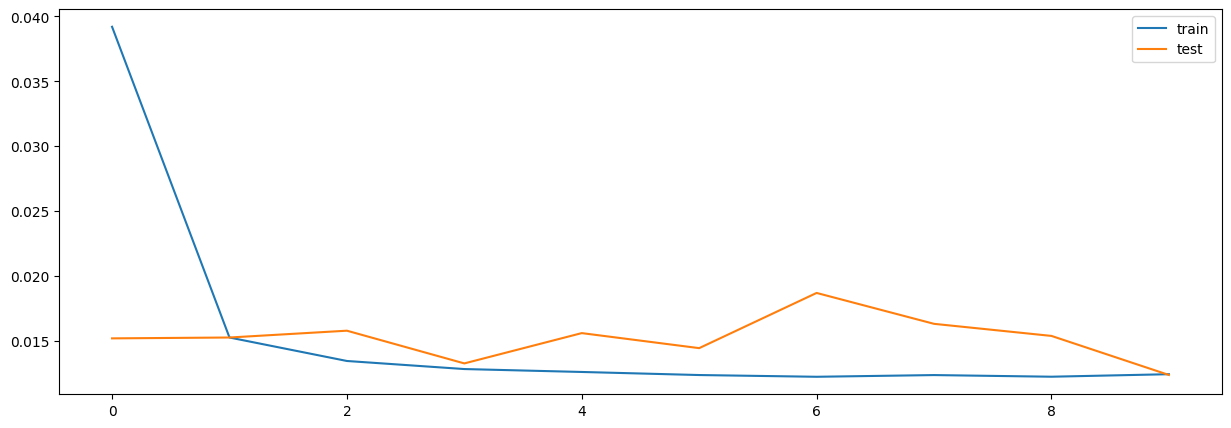

In [73]:
# Train Model

epochs = 10
callbacks = [early_stop]

history = _fit_model(model, epochs, train_X, train_y, val_X, val_y, callbacks)
_plot_history(history)

<h3>5. Evaluate</h3>

In [74]:
# Get Predictions

preds = model.predict(test_X).squeeze()    
preds_test_df['pol_value_pred'] = preds
error = np.mean(np.abs(preds_test_df['pol_value_pred']-preds_test_df['pol_value_label_sum']))
print("MAE: {}".format(np.round(error, 4)))

139/139 [==============================] - 0s 978us/step
MAE: 0.0835


<h4>5.1 Error Analysis</h4>

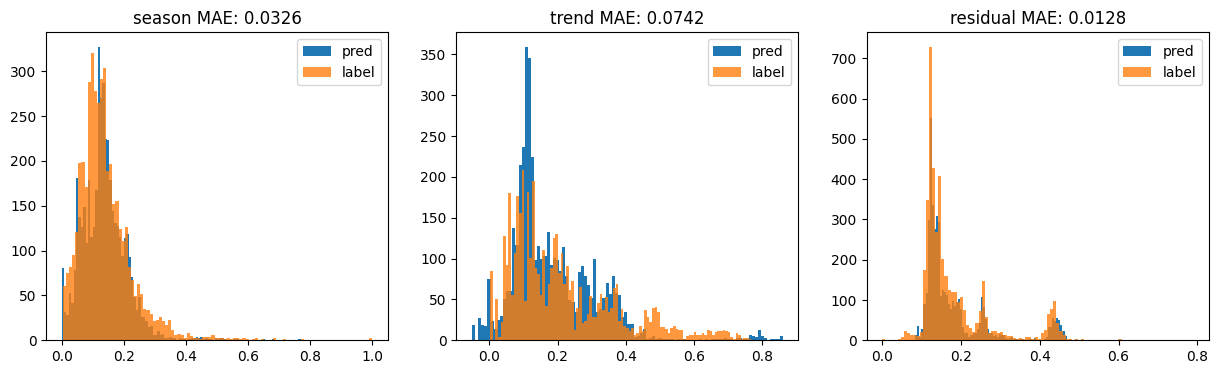

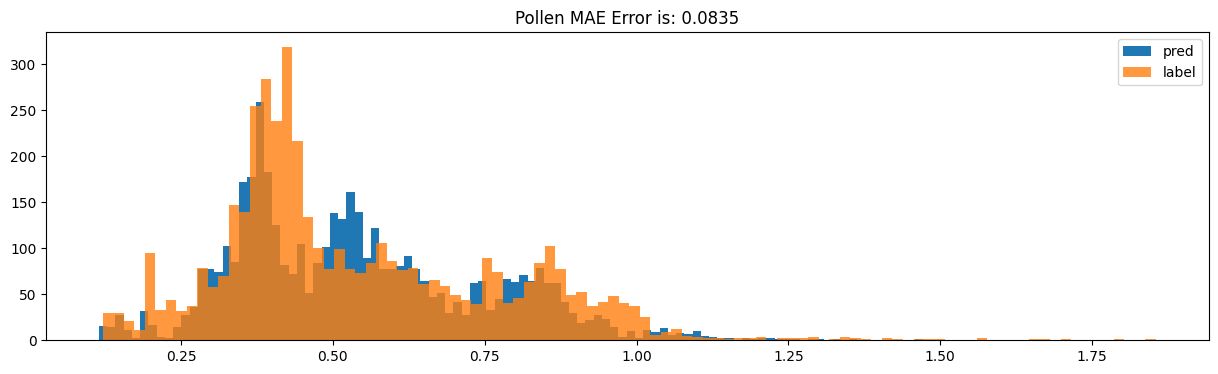

In [75]:
# Plot Prediction & Label Distr
    
_plot_error_distr(preds_test_df)

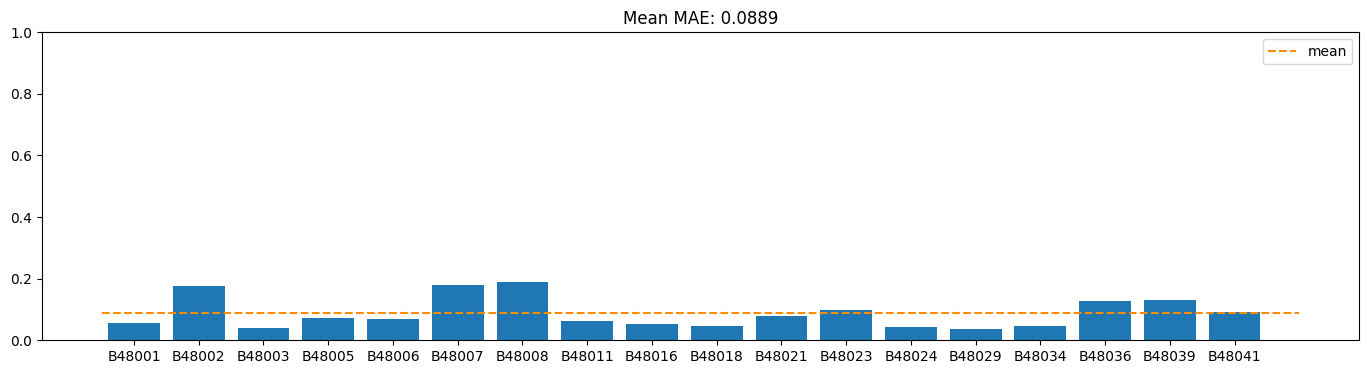

In [76]:
# Plot BCode Error
    
_plot_bcode_error(preds_test_df)

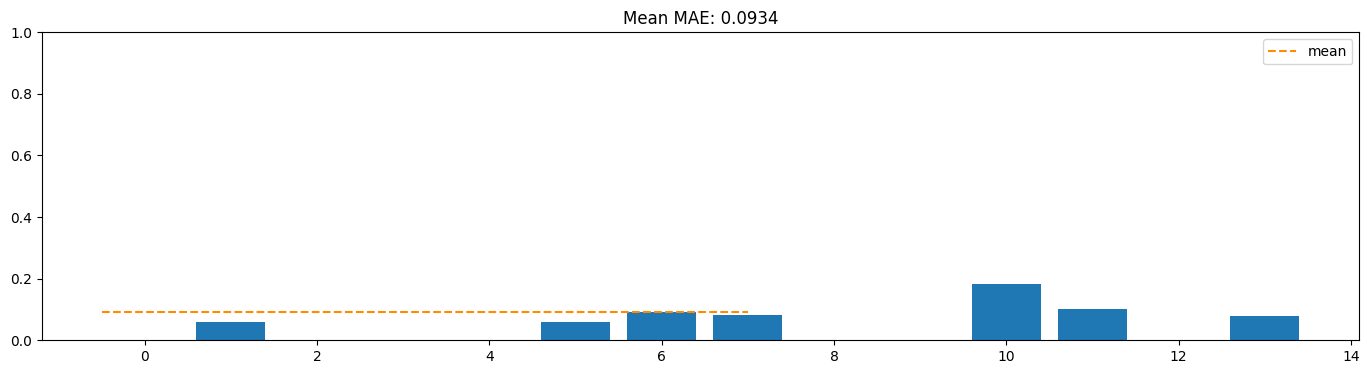

In [77]:
# Plot Station Error

_plot_station_error(preds_test_df)

<h4>5.2 Show Predictions</h4>

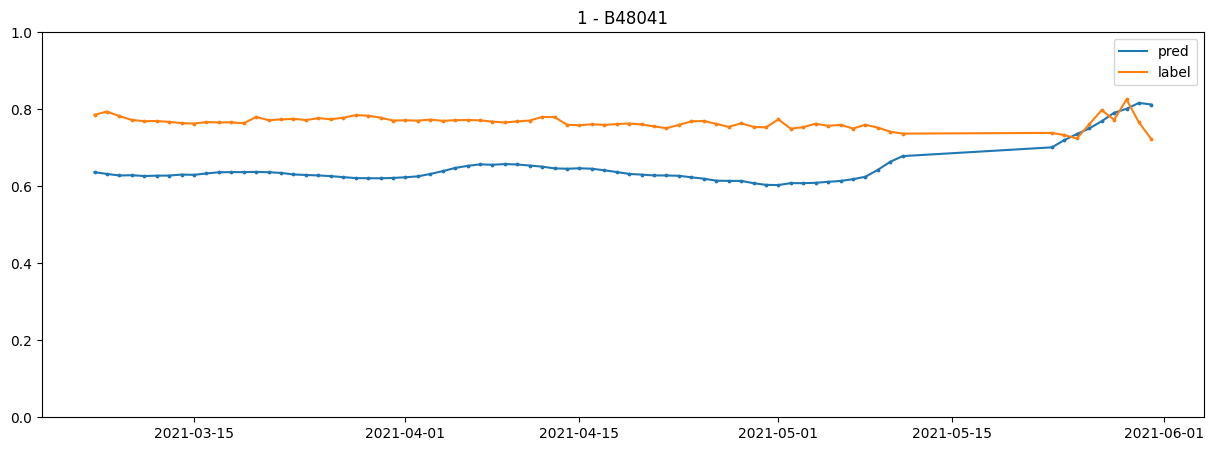

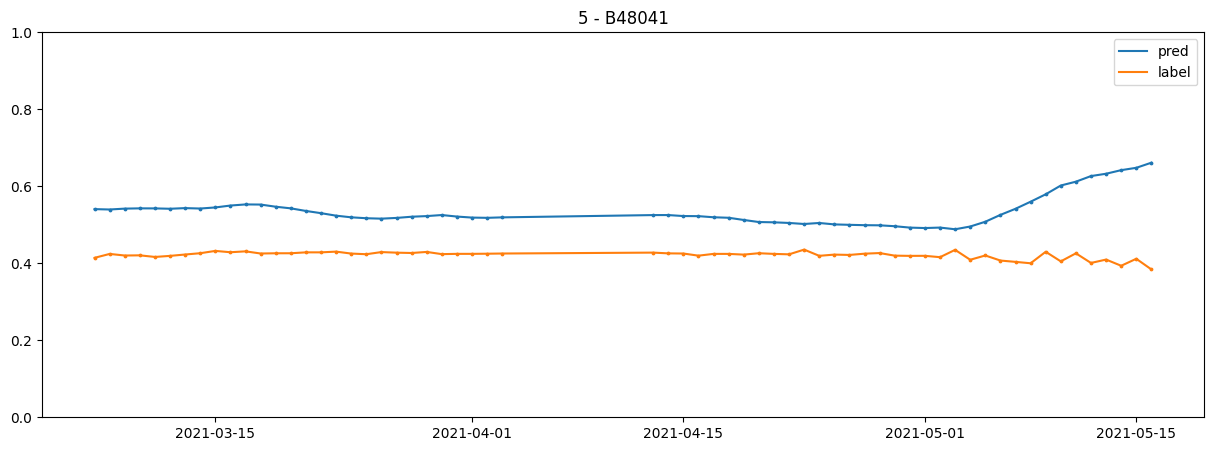

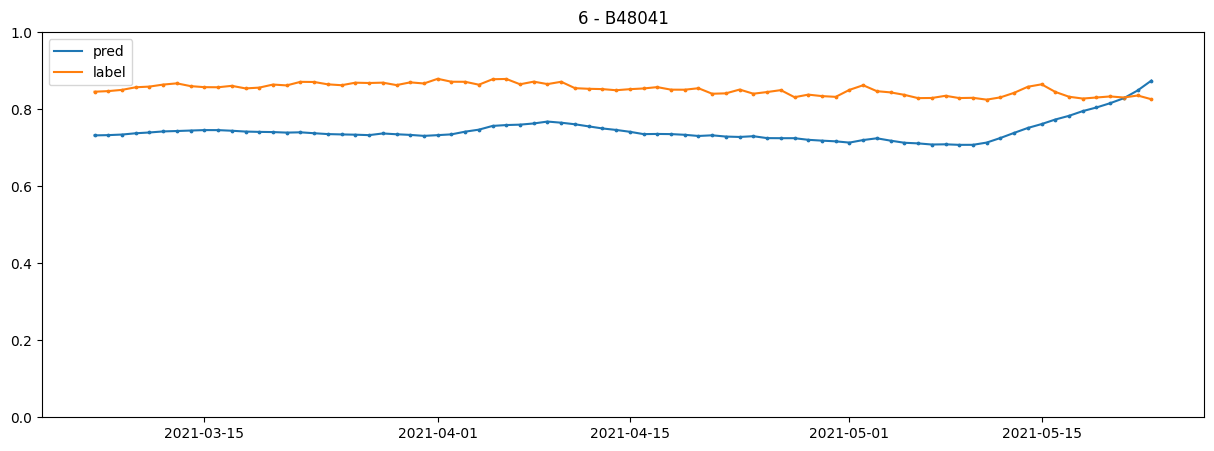

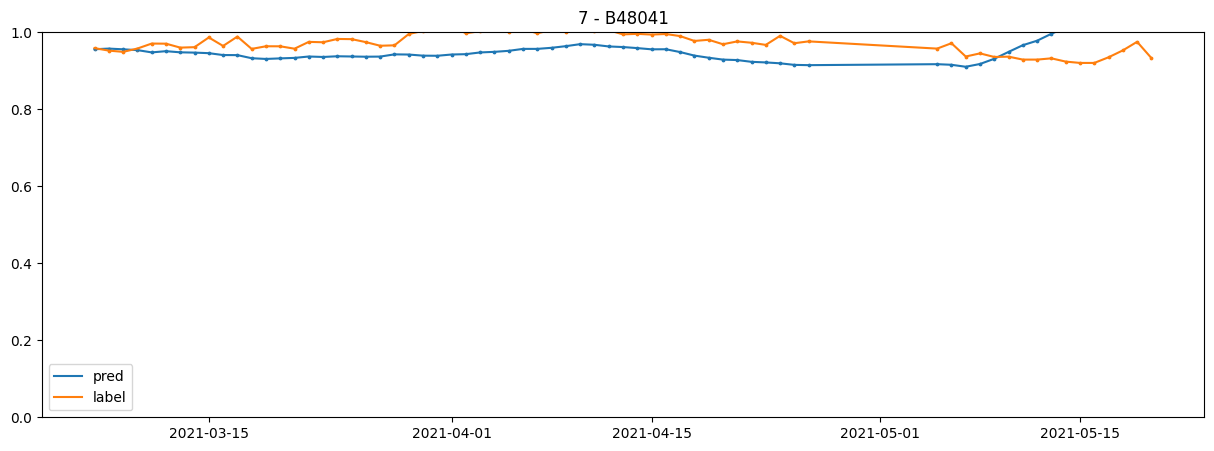

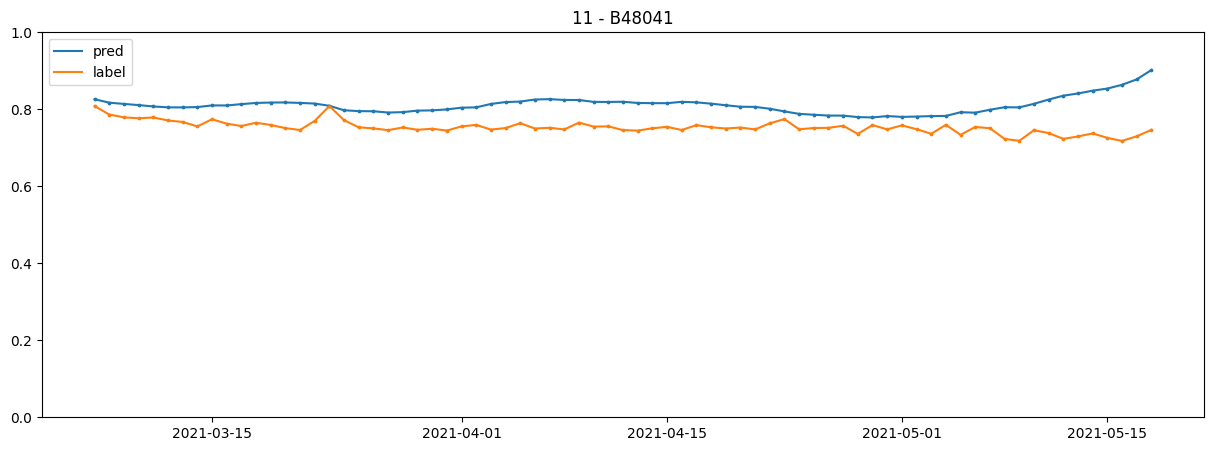

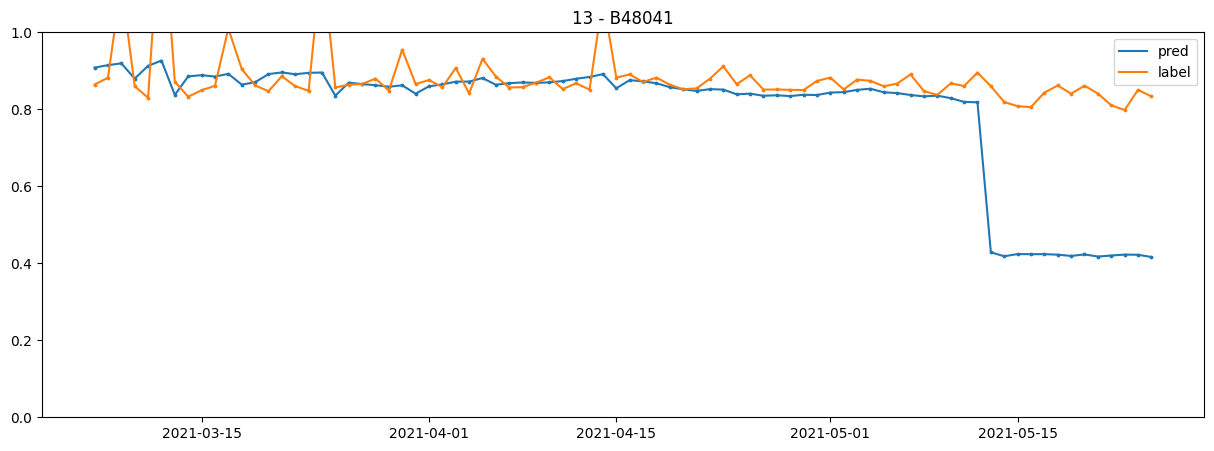

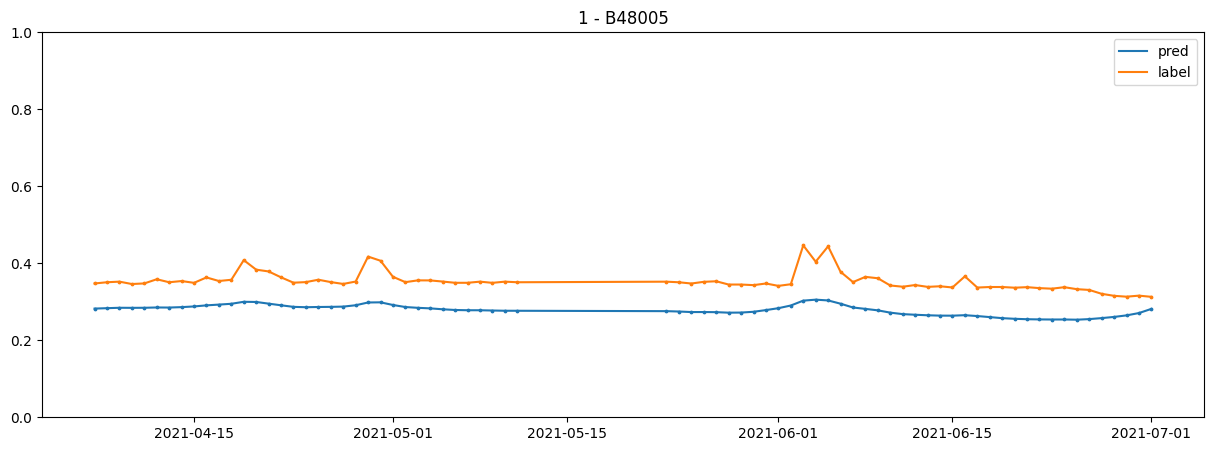

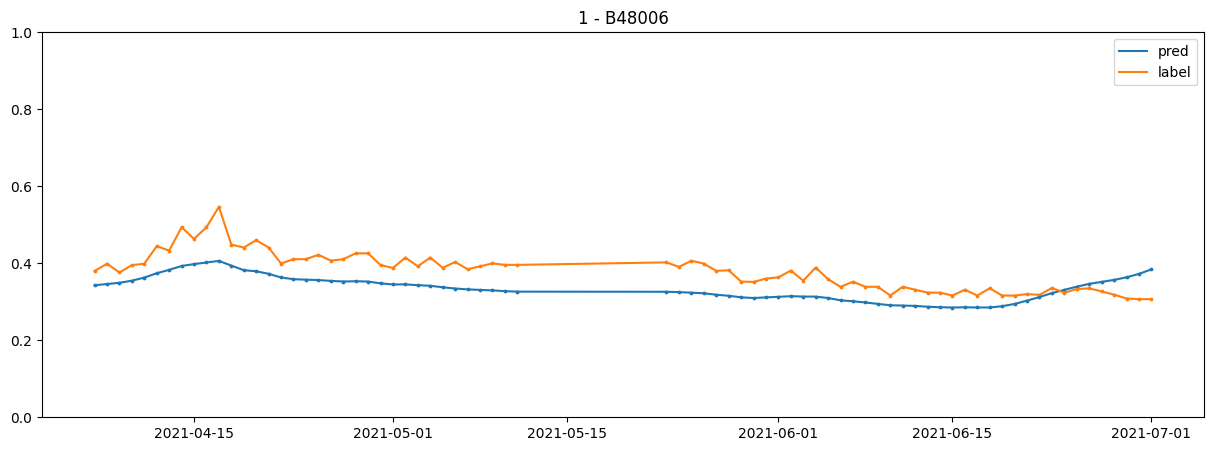

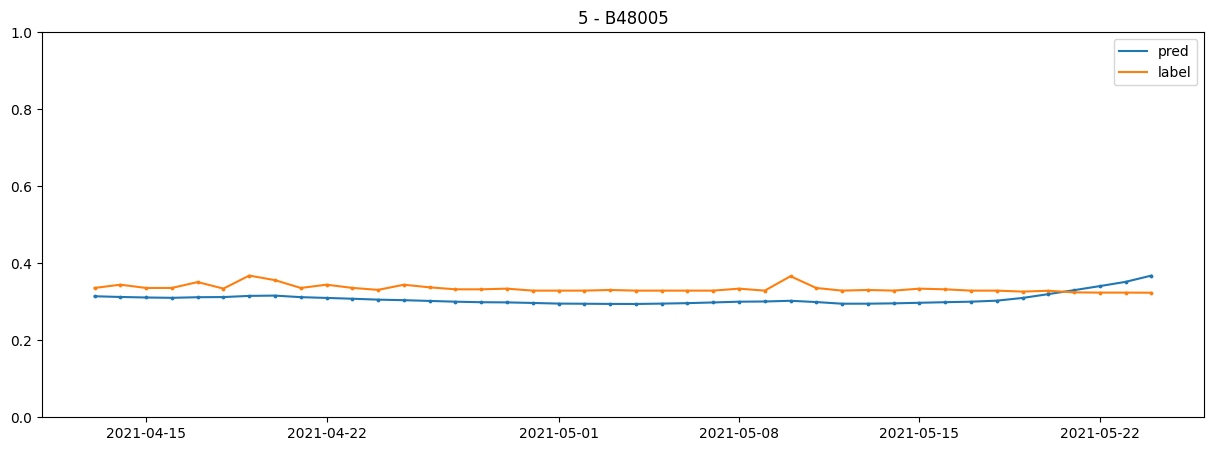

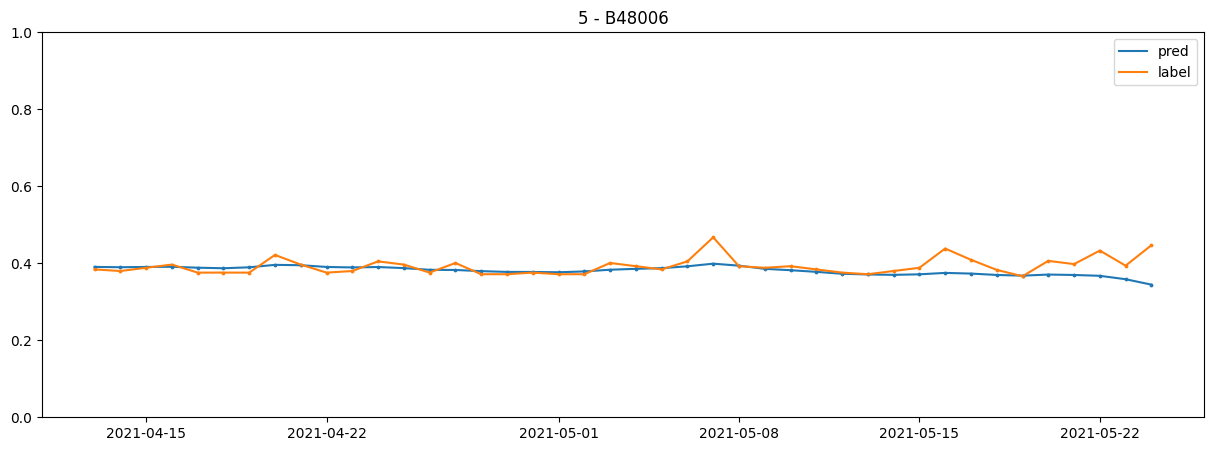

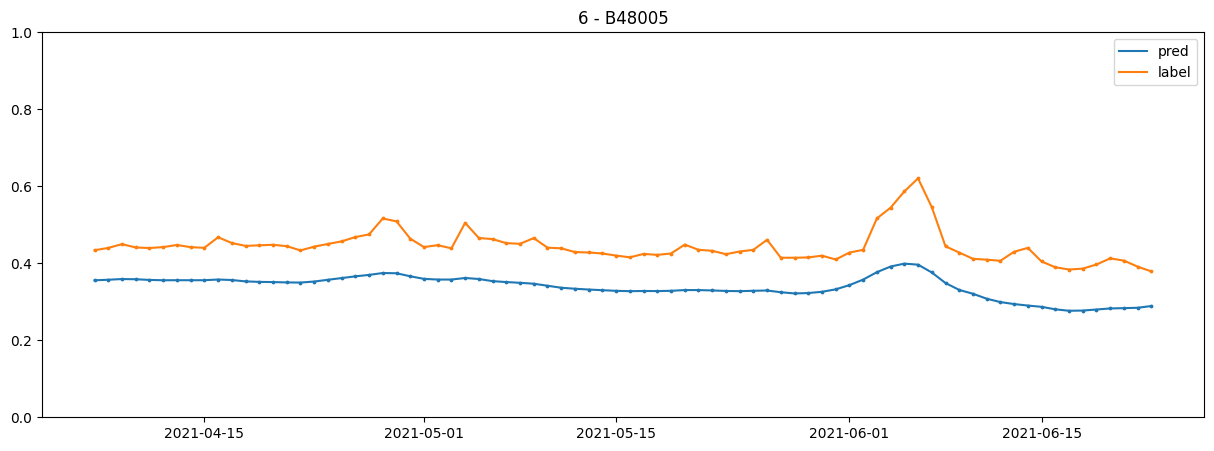

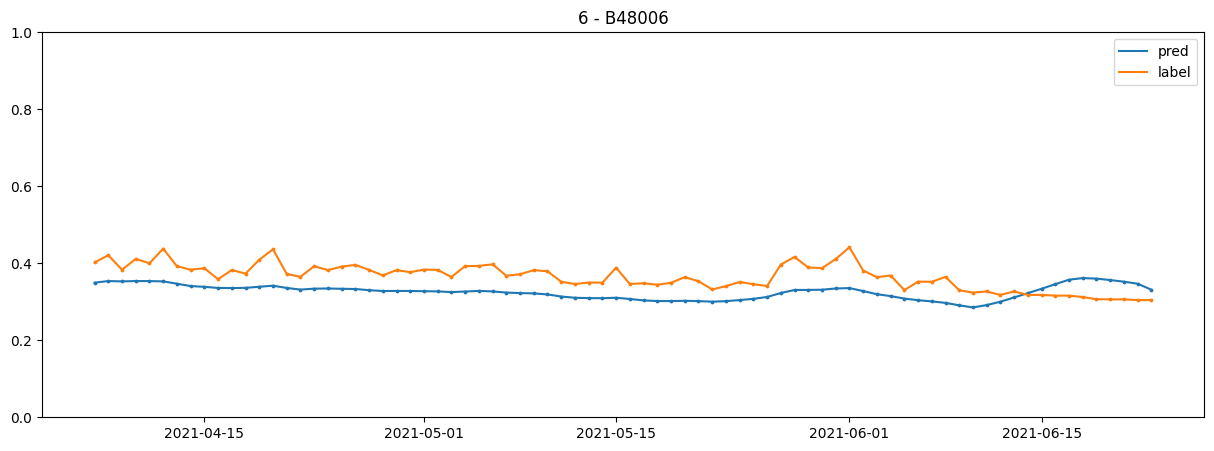

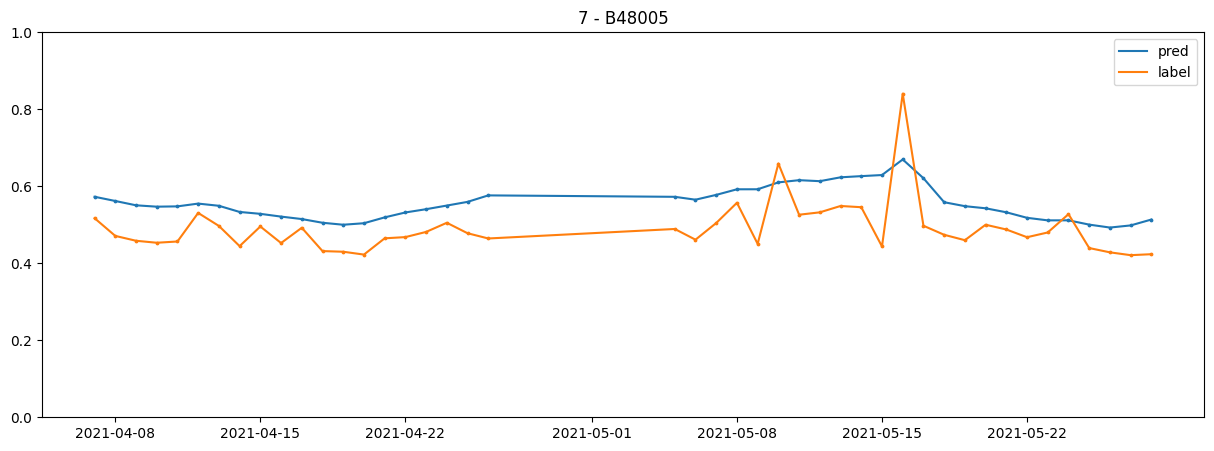

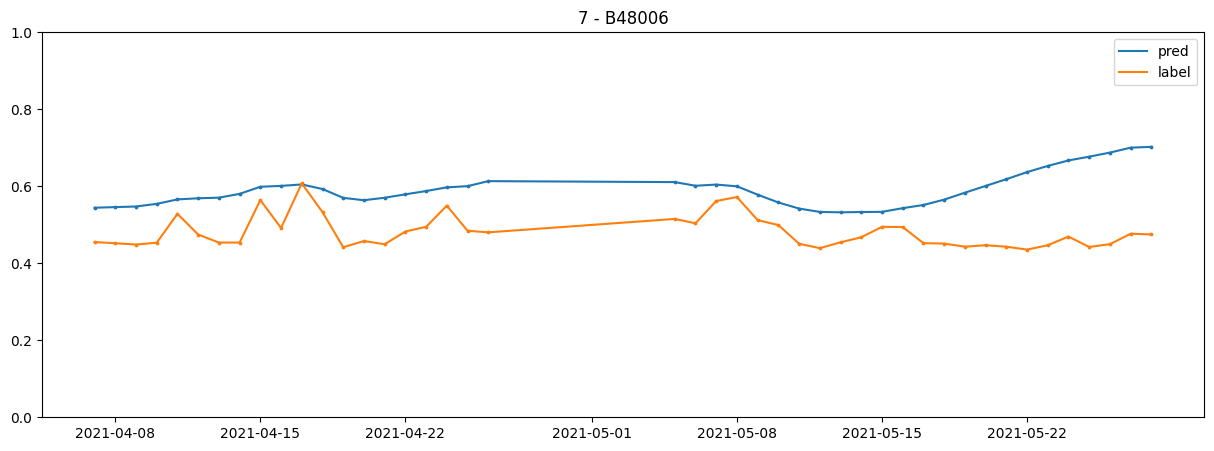

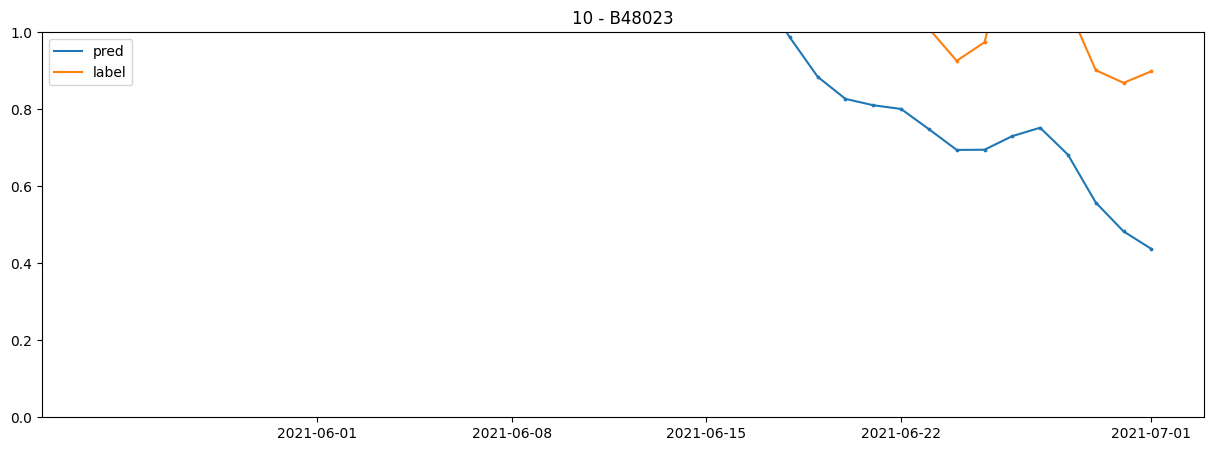

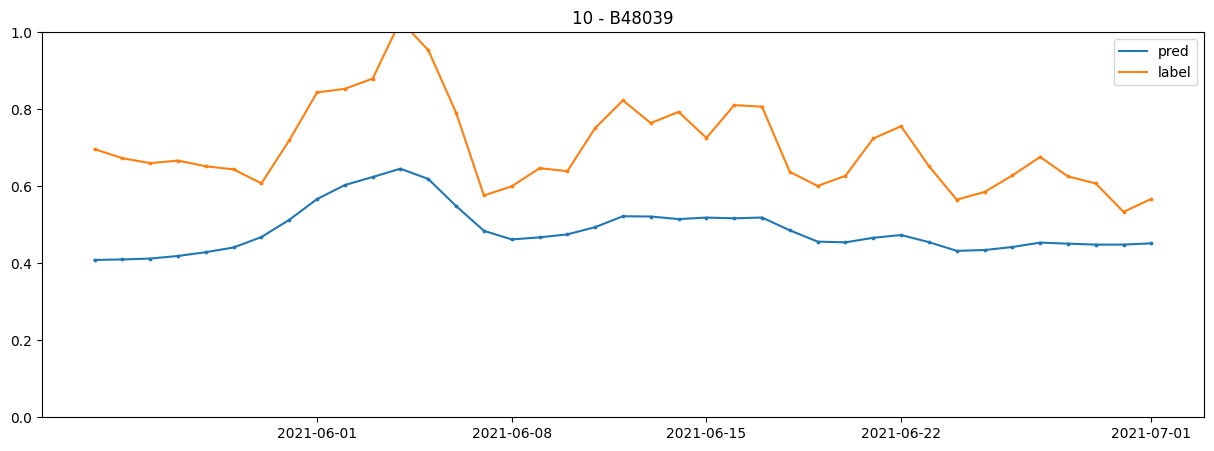

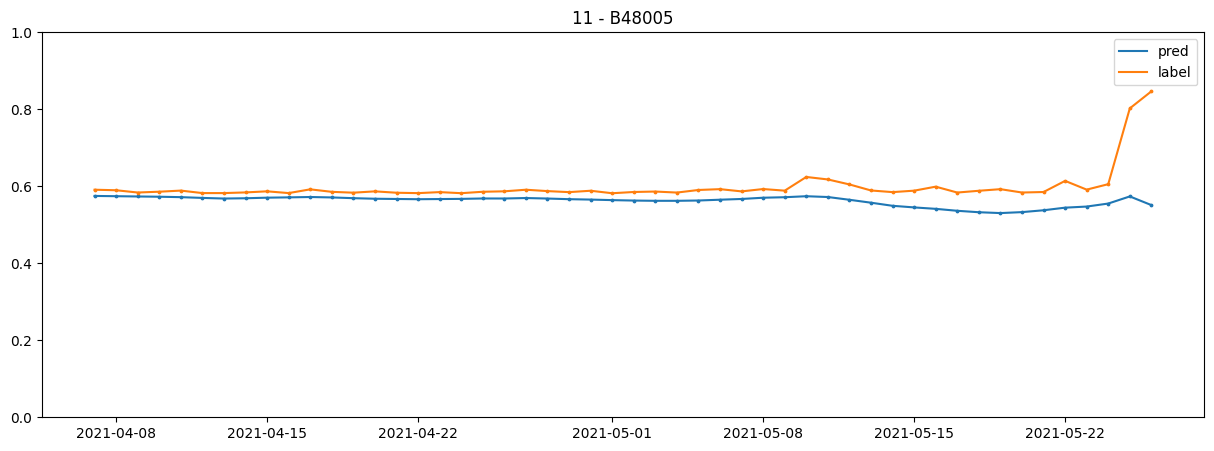

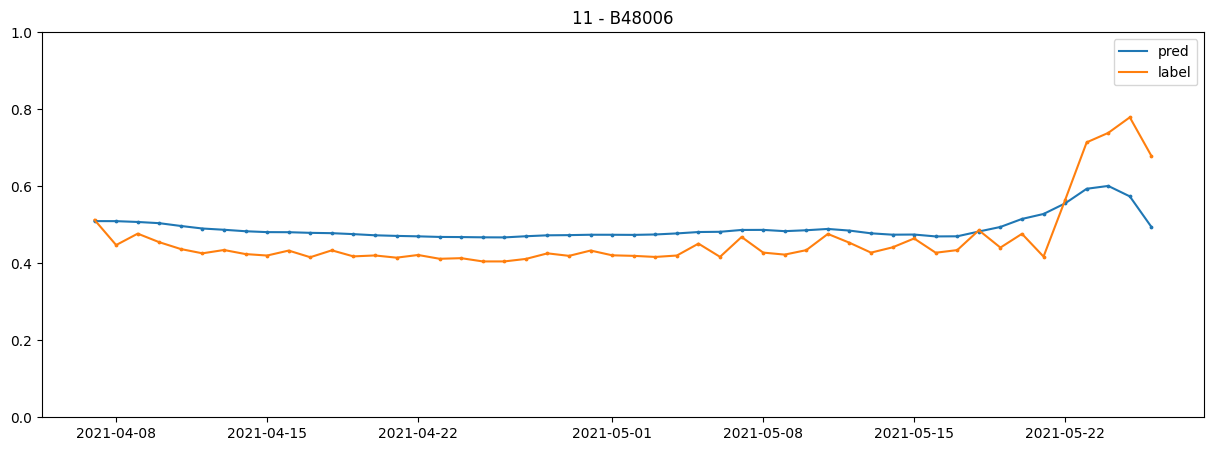

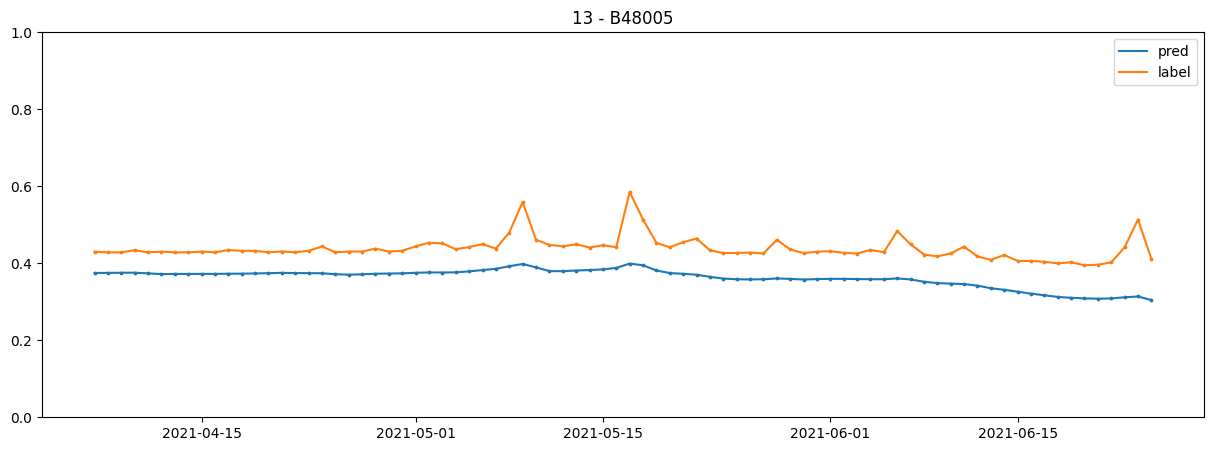

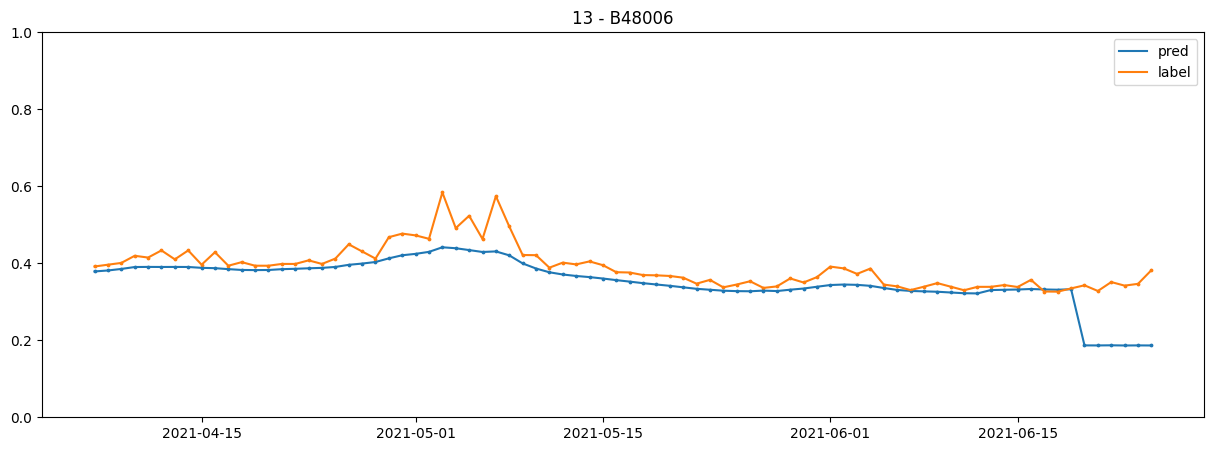

In [78]:
N_TO_SHOW = 20
pred_col = 'pol_value_pred' # pol_value_pred_sum
label_col = 'pol_value_label_sum' # pol_value_label_sum

for station_id, pol_var_id in preds_test_df[['station_id', 'pol_var_id']].drop_duplicates().values[:N_TO_SHOW]:
    # Get data
    curr_df = preds_test_df[(preds_test_df['station_id']==station_id) & 
                            (preds_test_df['pol_var_id']==pol_var_id)]    
    curr_df.sort_values(by='date', inplace=True)
    # Plot
    plt.figure(figsize=(15, 5))
    plt.title("{} - {}".format(station_id, pol_var_id))
    plt.plot(curr_df['date'], curr_df[pred_col], label='pred')
    plt.scatter(curr_df['date'], curr_df[pred_col], s=3)
    plt.plot(curr_df['date'], curr_df[label_col], label='label')
    plt.scatter(curr_df['date'], curr_df[label_col], s=3)
    plt.legend()
    plt.ylim(0, 1)
    plt.show()